<a href="https://colab.research.google.com/github/mohamedyosef101/101_learning_area/blob/area/Time%20Series/energy_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting with Engergy Consumption data
**Source**: [Time Series Forecasting with XGBoost](https://youtu.be/vV12dGe_Fho?si=vYrGFNEIDf2xxY0k) & [Part 2](https://youtu.be/z3ZnOW-S550?si=LSnNleUdMaZTxC1s) by Rob Mulla.

In [1]:
# setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # viz
import seaborn as sns # viz
import os # operating system
import xgboost as xgb # model

# evaluation
from sklearn.metrics import mean_squared_error as mse

# style
sns.set_style('whitegrid', {'grid.color': "lightgray"})

# _1. Get the data
**Source**: Rob Mulla. 2018. [Hourly Energy Consumption](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption). Kaggle Datasets.

From the dataset, I'll use `PJME_hourly.csv`.
> ⚠ Since I work on colab, I'll use a version of the data file from my GitHub repo because I don't want to bother myself with the Kaggle API drama.

In [2]:
# Read the data with pandas
URL = 'https://github.com/mohamedyosef101/101_learning_area/raw/area/Time%20Series/data/PJME_hourly.csv'
data = pd.read_csv(URL)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


From this little info, we get the we have 145k observations. Also, there is no missing values.

# _2. Data Exploration

In [3]:
# Rename the data
data = data.rename(columns={'Datetime': 'dt', 'PJME_MW': 'target'})
data.tail(3)

,dt,target
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [5]:
# set the index as datetime
data = data.set_index('dt')
data.index = pd.to_datetime(data.index)

# make sure that the data is sorted
data = data.sort_index(ascending=True)

data.head(3)

,target
dt,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0


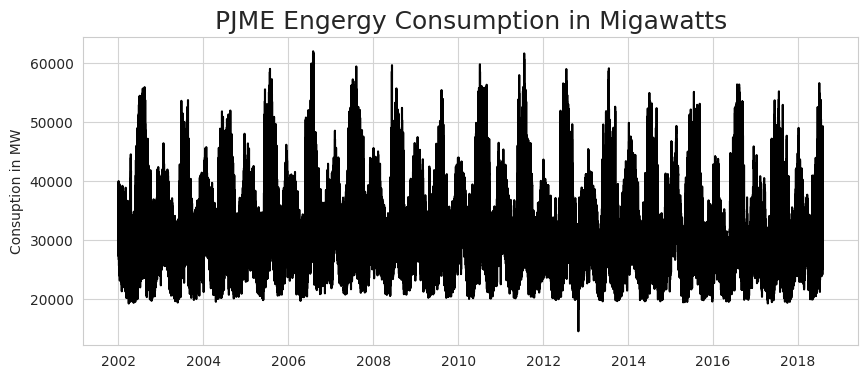

In [14]:
# Plot the data
plt.figure(figsize=(10, 4))
plt.plot(data['target'], color='black')
plt.title("PJME Engergy Consumption in Migawatts", fontsize=18)
plt.ylabel("Consuption in MW")
plt.show()

From the plot, our data range from 2002 to 2018

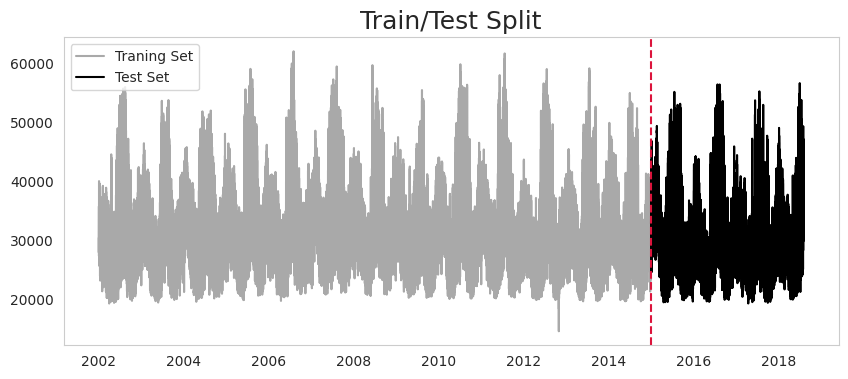

In [32]:
# train/test split by years
train = data.loc[data.index < '2015-01-01'] # everything before 2015
test = data.loc[data.index >= '2015-01-01'] # 2015 and after
split_date = pd.to_datetime('2015-01-01')

# plot the split
plt.figure(figsize=(10, 4))
plt.plot(train.target, label="Traning Set", color='darkgray')
plt.plot(test.target, label="Test Set", color='black')
plt.axvline(split_date, color='crimson', ls='--')
plt.legend(loc='best')
plt.title("Train/Test Split", fontsize=18)
plt.grid(False)
plt.show()

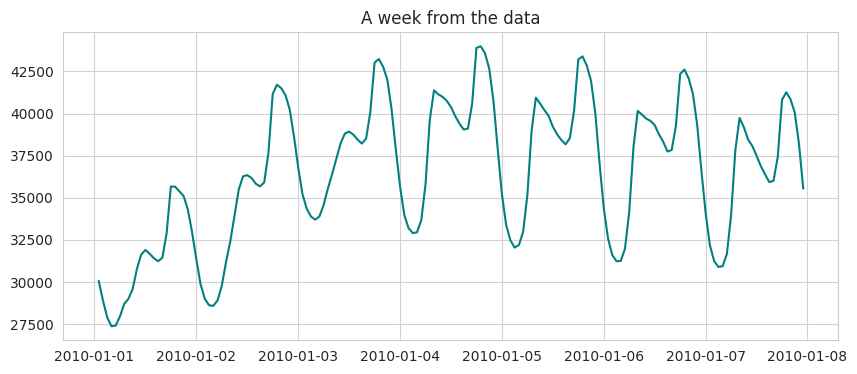

In [39]:
# Explore a week of the data
week = data.loc[(data.index > '2010-01-01') & (data.index < '2010-01-08')]
plt.figure(figsize=(10, 4))
plt.plot(week, color='teal')
plt.title("A week from the data")
plt.show()

# _3. Feature Engineering


In [40]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [41]:
data = create_features(data)

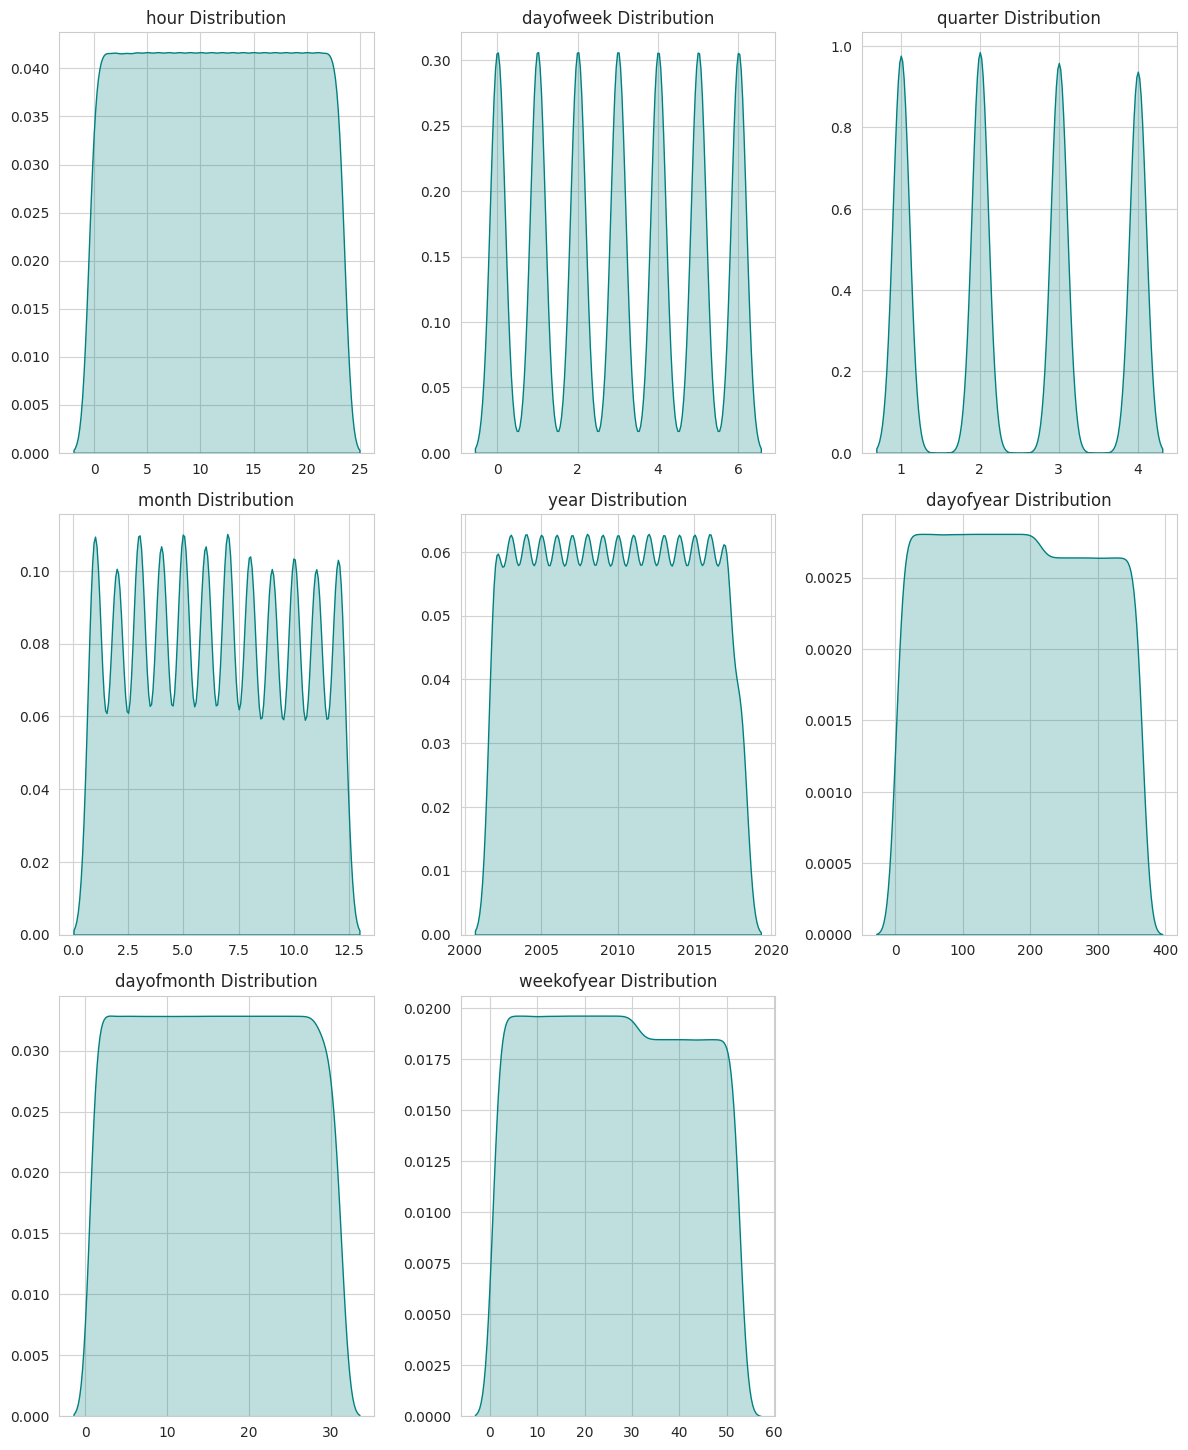

In [49]:
# Get the distribution of every feature vs. target
features = data.drop('target', axis=1)
cols=features.columns
fig = plt.figure(figsize=(12, 3*len(cols)))
for i, col in enumerate(cols):
    ax=fig.add_subplot(5, 3, i+1)
    sns.kdeplot(data, x=col, axes=ax, color="teal", fill=True)
    ax.set_title(f"{col} Distribution")
    ax.set(xlabel=None, ylabel=None)
fig.tight_layout()
plt.show()